In [1]:
import json
import warnings

import matplotlib.pyplot as plt
import mplcyberpunk
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from matplotlib.pyplot import figure
from pandas import Series
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

plt.ioff()
PARAMS_PATH = "../config/params.yml"
warnings.filterwarnings("ignore")

# Описание задачи

https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/discussion

Задача бинарной классификации для предсказания вероятности дефолта по кредиту (target = 1).

Отсутствие кредитной истории может означать многое, включая молодой возраст или предпочтение наличных денег. Без традиционных данных человеку, у которого практически нет кредитной истории, скорее всего, будет отказано. Поставщики потребительского кредитования должны точно определить, какие клиенты могут погасить кредит, а какие нет, и данные имеют решающее значение. Если бы наука о данных могла помочь лучше прогнозировать возможности погашения долга, кредиты могли бы стать более доступными для тех, кто может получить от них наибольшую выгоду.

В настоящее время поставщики потребительского кредитования используют различные статистические методы и методы машинного обучения для прогнозирования кредитного риска. Эти модели обычно называют картами показателей. В реальном мире поведение клиентов постоянно меняется, поэтому каждую систему показателей необходимо регулярно обновлять, а это требует времени. Стабильность системы показателей в будущем имеет решающее значение, поскольку внезапное падение производительности означает, что кредиты в среднем будут выдаваться худшим клиентам. Суть проблемы заключается в том, что поставщики кредитов не могут обнаружить потенциальные проблемы раньше, чем станут заметны первые сроки погашения этих кредитов. Учитывая время, необходимое для повторной разработки, проверки и внедрения системы показателей, стабильность крайне желательна. Существует компромисс между стабильностью модели и ее производительностью, и перед развертыванием необходимо достичь баланса.

Данная работа по оценке рисков дефолта потенциальных клиентов позволит поставщикам потребительского кредитования принимать больше заявок на кредит. Это может улучшить жизнь людей, которым исторически отказывали в кредите из-за отсутствия кредитной истории.

## Описание полей

- case_id - Уникальный идентификатор.
- WEEK_NUM - номер недели, используется для группировки и расчета метрики gini stability.
- age_years - Возраст клиента.
- employedfrom - Общий трудовой стаж (в днях относительно даты записи).
- incometype_1044T - Вид дохода.
- pmtnum_254L - Общее количество платежей по кредиту, осуществленных клиентом. 
- num_cred_closed - Количество закрытых кредитов.
- annuity_780A - Размер ежемесячного платежа.
- debt_outstand_total - Общая сумма непогашенного долга.
- isbidproduct - Флаг, указывающий, является ли продукт перекрестной продажей.
- numberofoverdueinstlmaxdat_148D - Сколько дней прошло с последней просрочки платежа по закрытому договору.
- total_amount_closed_contracts - Общая сумма закрытых контрактов.
- credamount_770A - Cумма активного кредита.
- num_cred_active - Количество активных кредитов.
- mobilephncnt_593L - Количество клиентов с таким же номером мобильного телефона.
- tax_amount_max - Максимальный размер налога.
- maininc_215A - Размер основного дохода.
- target - Целевой признак. 1: Был дефолт по кредиту, 0: Дефолта не было

# EDA

In [2]:
with open(PARAMS_PATH, "r") as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
preproc = config["preprocessing"]

raw_data из себя представляет случайную выборку размером 100_000 из исходной выборки в 1.5 млн строк.

In [3]:
raw_data = pd.read_parquet(preproc["raw_data_path"])
raw_data.set_index(preproc["index_col"], inplace=True)
raw_data.drop(preproc["drop_columns"], axis=1, inplace=True)
raw_data

,WEEK_NUM,target,days30_165L,maritalst_385M,pmtscount_423L,requesttype_4525192L,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avgoutstandbalancel6m_4187114A,...,purposeofcred_active,residualamount_closed,subjectrole_active,subjectrole_closed,empladdr,num_total_inst,num_total_paid_inst,cred_closure_date_days_ago,actualdpd,sellerplace_cnt
case_id,,,,,,,,,,,,,,,,,,,,,
1020556.0,89,0,1.0,0.0,NaN,None,2079.8000,0.0,NaN,NaN,...,a55475b1,NaN,a55475b1,a55475b1,a55475b1,0.0,NaN,-1891.0,NaN,0
1323846.0,12,0,0.0,2.0,17.0,None,2417.6000,1115.4,1115.4,17096.553,...,a55475b1,NaN,a55475b1,a55475b1,a55475b1,26.0,8.0,NaN,0.0,0
791835.0,35,0,0.0,2.0,0.0,DEDUCTION_6,3195.4001,0.0,NaN,NaN,...,a55475b1,NaN,a55475b1,a55475b1,P8_43_166,0.0,NaN,NaN,NaN,0
1942234.0,91,0,0.0,2.0,NaN,None,5585.2000,12626.2,9651.0,92430.650,...,a55475b1,NaN,a55475b1,a55475b1,a55475b1,74.0,74.0,-3.0,0.0,4
1719341.0,51,0,0.0,0.0,NaN,DEDUCTION_6,2019.0000,0.0,2987.6,NaN,...,a55475b1,0.0,a55475b1,a55475b1,a55475b1,27.0,30.0,-61.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822265.0,63,0,0.0,1.0,NaN,DEDUCTION_6,7155.2000,10458.0,10458.0,167196.200,...,60c73645,NaN,a55475b1,a55475b1,a55475b1,18.0,8.0,-149.0,0.0,1
1792196.0,59,0,0.0,2.0,NaN,DEDUCTION_6,2239.4001,3900.0,5060.2,33102.934,...,60c73645,NaN,a55475b1,a55475b1,a55475b1,22.0,21.0,-121.0,0.0,2
1025317.0,91,0,0.0,2.0,NaN,None,3998.2000,0.0,NaN,NaN,...,a55475b1,0.0,a55475b1,a55475b1,a55475b1,0.0,NaN,-2870.0,NaN,0


In [735]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 100000 entries, 1020556.0 to 1912905.0
Columns: 190 entries, WEEK_NUM to sellerplace_cnt
dtypes: float64(130), int32(10), int64(1), int8(1), object(48)
memory usage: 141.2+ MB


In [736]:
raw_data[preproc["relevant_columns"]].info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 100000 entries, 1020556.0 to 1912905.0
Data columns (total 15 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   age_years                        100000 non-null  int32  
 1   employedfrom                     81678 non-null   float64
 2   pmtnum_254L                      97033 non-null   float64
 3   num_cred_closed                  80699 non-null   float64
 4   annuity_780A                     100000 non-null  float64
 5   credamount_770A                  100000 non-null  float64
 6   debt_outstand_total              100000 non-null  float64
 7   isbidproduct                     100000 non-null  int8   
 8   numberofoverdueinstlmaxdat_148D  47547 non-null   float64
 9   incometype_1044T                 100000 non-null  object 
 10  total_amount_closed_contracts    64524 non-null   float64
 11  num_cred_active                  82866 non-null   fl

In [737]:
raw_data[preproc["relevant_columns"]].describe()

,age_years,employedfrom,pmtnum_254L,num_cred_closed,annuity_780A,credamount_770A,debt_outstand_total,isbidproduct,numberofoverdueinstlmaxdat_148D,total_amount_closed_contracts,num_cred_active,mobilephncnt_593L,tax_amount_max,maininc_215A
count,100000.000000,81678.000000,97033.000000,80699.000000,100000.000000,100000.000000,100000.000000,100000.000000,47547.000000,6.452400e+04,82866.000000,100000.000000,62031.000000,66439.000000
mean,44.121150,-2926.926908,17.101625,6.531494,4031.647315,49796.753027,19861.477437,0.115060,-1131.416514,2.063838e+05,2.055994,1.771020,9768.718303,49576.200919
std,14.047226,2620.787079,9.808164,6.214334,2998.792479,43834.355049,50725.246272,0.319096,1114.199166,1.434213e+06,1.104814,1.137172,15453.441888,32286.269011
min,20.000000,-20647.000000,3.000000,0.000000,154.200000,2000.000000,0.000000,0.000000,-5408.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,32.000000,-4010.000000,12.000000,2.000000,1968.350025,19998.000000,0.000000,0.000000,-1570.000000,3.667070e+04,1.000000,1.000000,1673.400050,30000.000000
50%,42.000000,-2174.000000,12.000000,5.000000,3152.400100,35394.000000,0.000000,0.000000,-711.000000,7.718400e+04,2.000000,1.000000,5092.400000,40000.000000
75%,56.000000,-1064.000000,24.000000,9.000000,5222.000000,64000.000000,14156.892250,0.000000,-327.000000,1.840000e+05,3.000000,2.000000,12111.383000,60000.000000
max,76.000000,13.000000,60.000000,280.000000,75602.000000,400000.000000,820761.600000,1.000000,12.000000,2.409166e+08,15.000000,19.000000,476843.400000,200000.000000


In [738]:
raw_data[preproc["relevant_columns"]].describe(include="object")

,incometype_1044T
count,100000
unique,8
top,PRIVATE_SECTOR_EMPLOYEE
freq,32121


Создадим файл размером в 1000 строк для predict from file.

In [6]:
df_check = raw_data.iloc[:1000]
df_check.drop('target', axis=1, inplace=True)
df_check

,WEEK_NUM,days30_165L,maritalst_385M,pmtscount_423L,requesttype_4525192L,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avgoutstandbalancel6m_4187114A,cntincpaycont9m_3716944L,...,purposeofcred_active,residualamount_closed,subjectrole_active,subjectrole_closed,empladdr,num_total_inst,num_total_paid_inst,cred_closure_date_days_ago,actualdpd,sellerplace_cnt
case_id,,,,,,,,,,,,,,,,,,,,,
1020556.0,89,1.0,0.0,NaN,None,2079.8000,0.0,NaN,NaN,NaN,...,a55475b1,NaN,a55475b1,a55475b1,a55475b1,0.0,NaN,-1891.0,NaN,0
1323846.0,12,0.0,2.0,17.0,None,2417.6000,1115.4,1115.4000,17096.5530,3.0,...,a55475b1,NaN,a55475b1,a55475b1,a55475b1,26.0,8.0,NaN,0.0,0
791835.0,35,0.0,2.0,0.0,DEDUCTION_6,3195.4001,0.0,NaN,NaN,NaN,...,a55475b1,NaN,a55475b1,a55475b1,P8_43_166,0.0,NaN,NaN,NaN,0
1942234.0,91,0.0,2.0,NaN,None,5585.2000,12626.2,9651.0000,92430.6500,26.0,...,a55475b1,NaN,a55475b1,a55475b1,a55475b1,74.0,74.0,-3.0,0.0,4
1719341.0,51,0.0,0.0,NaN,DEDUCTION_6,2019.0000,0.0,2987.6000,NaN,0.0,...,a55475b1,0.0,a55475b1,a55475b1,a55475b1,27.0,30.0,-61.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860994.0,75,1.0,2.0,NaN,None,8695.4000,0.0,13655.4000,-4085.4001,3.0,...,60c73645,0.0,a55475b1,a55475b1,a55475b1,16.0,16.0,-214.0,0.0,3
1325574.0,12,2.0,3.0,9.0,None,5418.2000,4995.2,3502.4001,11823.1430,7.0,...,96a8fdfe,NaN,a55475b1,a55475b1,a55475b1,25.0,22.0,NaN,0.0,1
2541088.0,5,0.0,0.0,0.0,None,3833.0000,0.0,3191.4001,NaN,8.0,...,a55475b1,NaN,a55475b1,a55475b1,a55475b1,56.0,59.0,NaN,0.0,5


In [9]:
type(df_check['pmtscount_423L'].iloc[0])

numpy.float64

In [7]:
df_check.to_parquet(preproc["check_data_path"])

In [15]:
cat_features = raw_data.select_dtypes(exclude=np.number).columns.tolist()
num_features = raw_data.select_dtypes(include=np.number).columns.tolist()
num_features.remove(preproc["target_col"])
num_features.remove(preproc["group_col"])

## Preprocessing

Заполним пропуски и переведем категориальный признаки из типа Object в category. Разделим обработанные данные на обучающую и тестовую выборку.

In [16]:
imputer_cat = SimpleImputer(missing_values=None, strategy="constant", fill_value="None")
raw_data[cat_features] = imputer_cat.fit_transform(raw_data[cat_features])
raw_data[cat_features] = raw_data[cat_features].astype("category")

Обработаем поля employedfrom и numberofoverdueinstlmaxdat_148D, заменим отрицательные значения на положительные.

In [17]:
for col in ["employedfrom", "numberofoverdueinstlmaxdat_148D"]:
    raw_data[col][raw_data[col] > 0] = 0
    raw_data[col] *= -1
raw_data[preproc["relevant_columns"]]

,age_years,employedfrom,pmtnum_254L,num_cred_closed,annuity_780A,credamount_770A,debt_outstand_total,isbidproduct,numberofoverdueinstlmaxdat_148D,incometype_1044T,total_amount_closed_contracts,num_cred_active,mobilephncnt_593L,tax_amount_max,maininc_215A
case_id,,,,,,,,,,,,,,,
1020556.0,39,NaN,12.0,3.0,2079.8000,24956.0,0.00,0,NaN,SALARIED_GOVT,275600.00,2.0,1.0,NaN,NaN
1323846.0,26,1429.0,16.0,3.0,2417.6000,28998.0,23278.00,0,NaN,PRIVATE_SECTOR_EMPLOYEE,NaN,4.0,2.0,50117.0,70000.0
791835.0,25,1330.0,16.0,NaN,3195.4001,36354.0,0.00,0,NaN,EMPLOYED,NaN,1.0,1.0,0.0,NaN
1942234.0,73,NaN,9.0,10.0,5585.2000,44165.8,93151.11,0,1017.0,RETIRED_PENSIONER,82600.00,2.0,1.0,NaN,31000.0
1719341.0,37,3454.0,24.0,12.0,2019.0000,48453.0,0.00,0,696.0,OTHER,600000.00,2.0,2.0,NaN,46000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822265.0,54,2197.0,12.0,9.0,7155.2000,70132.0,156701.20,0,1662.0,PRIVATE_SECTOR_EMPLOYEE,272501.34,3.0,3.0,5599.0,62000.0
1792196.0,57,2472.0,12.0,4.0,2239.4001,26872.0,23269.60,0,170.0,EMPLOYED,105447.00,2.0,2.0,75.8,42000.0
1025317.0,54,NaN,12.0,3.0,3998.2000,47978.0,0.00,0,NaN,SELFEMPLOYED,120000.00,NaN,1.0,NaN,NaN


Так как raw_data уже случайным образом перемешана, просто разделим на train и test.

In [18]:
train_data = raw_data.iloc[1000:81_000]

In [745]:
train_data.to_parquet(preproc["train_data_path"])
raw_data.iloc[81_000:].to_parquet(preproc["test_data_path"])

## Unique values

Сохраним уникальные, минимальные и максимальные значения для форм ввода данных.

In [746]:
def save_unique_cat_values(data: pd.DataFrame, cols: list[str], path: str) -> None:
    """
    Save .json file into path with unique values per categorical features (cols) in data.

    Parameters
    ----------
    data : pd.DataFrame
        Dataset
    cols: list[str]
        categorical features names
    path: str
        to save .json file
    """
    dict_unique = {col: data[col].unique().to_list() for col in cols}
    with open(path, "w") as file:
        json.dump(dict_unique, file)

In [747]:
def save_min_max_num_values(data: pd.DataFrame, cols: list[str], path: str) -> None:
    """
    Save .json file into path with (min, max, default values, have_nan flag) of numerical features in data.

    Parameters
    ----------
    data : pd.DataFrame
        Dataset
    cols: list[str]
        categorical features names
    path: str
        to save .json file
    """
    dict_vals = {
        col: (
            data[col].min().astype(float),
            data[col].max().astype(float),
            data[col].median().astype(float),
            data[col].isnull().values.any().astype(float),
        )
        for col in cols
    }
    with open(path, "w") as file:
        json.dump(dict_vals, file)

In [748]:
save_unique_cat_values(raw_data, cat_features, preproc["uniq_cat_values_path"])

In [749]:
save_min_max_num_values(raw_data, num_features, preproc["min_max_num_values_path"])

Далее детальнее изучим данные с помощью графиков.

## Гипотезы

In [30]:
from scipy import stats
from scipy.stats import mannwhitneyu


def check_normal(x: pd.DataFrame, pvalue_threshold: float = 0.05) -> tuple[bool, float]:
    """
    Perform the Shapiro-Wilk test for normality.

    The Shapiro-Wilk test tests the null hypothesis that the
    data was drawn from a normal distribution.

    Parameters
    ----------
    x : array_like
        Array of sample data.

    pvalue_threshold : float
        default = 0.05

    Returns
    -------
    normal : bool
        True if x has a normal distribution (p-value >= pvalue_threshold)
    p-value : float
        The p-value for the hypothesis test.
    """
    pvalue = stats.shapiro(x).pvalue
    return pvalue >= pvalue_threshold, np.round(pvalue, 5)


def check_distributions_for_similarity(
    df: pd.DataFrame, col_name: str, target_col: str, **kwargs
) -> None:
    """
    Print normality test results for target = 1 and 0
    If both are normal - perform Ttest and bootstrap test
    else perform Mann-Whitney U rank test on two independent samples

    Parameters
    ----------
    df: pd.DataFrame

    col_name : str
        feature name

    target_col : str
        target feature name

    Returns
    -------
    None
    """
    df_1 = df[df[target_col] == 1]
    df_0 = df[df[target_col] == 0]
    check_normal_1 = check_normal(df_1[col_name])
    check_normal_0 = check_normal(df_0[col_name])
    for res, group_name in [(check_normal_1, "1"), (check_normal_0, "0")]:
        print(
            f"Распределение для признака {col_name} target = {group_name} {'' if res[0] else 'не '}нормальное, pvalue = {res[1]}"
        )
    df_0 = df_0.dropna()
    df_1 = df_1.dropna()
    if all([check_normal_0[0], check_normal_1[0]]):
        data_0 = df_0[col_name].values
        data_1 = df_1[col_name].values
        t_test(data_0, data_1)
    else:
        statistic, pvalue = mannwhitneyu(df_1, df_0)
        check_pvalue(pvalue)
        print(
            f" Mann–Whitney U Test for {col_name}: statistic={np.round(statistic, 5)}, p-value={np.round(pvalue, 5)}"
        )


def t_test(data1: np.ndarray, data2: np.ndarray) -> None:
    """
    Calculate the T-test for the means of *two independent* samples of scores.

    Parameters
    ----------
    data1: np.ndarray
    data2: np.ndarray

    Returns
    -------
    None
    """
    data1 = data1[~np.isnan(data1)]
    data2 = data2[~np.isnan(data2)]
    statistic, pvalue = stats.ttest_ind(data1, data2)
    check_pvalue(pvalue)
    print(f"T test statistic = {statistic}, pvalue = {pvalue}")


def check_pvalue(pvalue: float) -> None:
    """
    Вывод результата по значению p_value

    Parameters
    ----------
    pvalue: float

    Returns
    -------
    None

    """
    try:
        if pvalue >= 0.05:
            print(f"Средние схожи, p-value={pvalue}")
        else:
            print(f"Средние различны, p-value={pvalue}")
    except TypeError as ex:
        print(f"message: {ex}")

In [555]:
def overlapping_densities(
    target_col: str,
    category_col: str,
    dark_mode: bool = True,
    title: str = "",
    x_label: str = "",
    **kwargs
) -> figure:
    """
    Plot Overlapping densities (‘ridge plot’)

    Parameters
    ----------
    target_col: str
        column name in the data

    category_col: str
        for hue

    dark_mode: bool, Default = True
        Use dark theme or not

    title: str,
        Figure title

    x_label: str,
        Name of x-axis

    Returns
    -------
    fig: figure
    """
    if dark_mode:
        plt.style.use("cyberpunk")
    else:
        plt.rcdefaults()
        sns.set_theme(style="white")
    plt.rcParams["axes.facecolor"] = (0, 0, 0, 0)
    if "label_x_pos" in kwargs:
        label_x_pos = kwargs.pop("label_x_pos")
    else:
        label_x_pos = 0.8
    x_lim = kwargs.pop("x_lim") if "x_lim" in kwargs else None

    # Initialize the FacetGrid object
    g = sns.FacetGrid(row=category_col, hue=category_col, **kwargs)

    # Draw the densities in a few steps
    g.map(
        sns.kdeplot,
        target_col,
        bw_adjust=0.5,
        clip_on=False,
        alpha=1,
        linewidth=1.5,
        fill=not dark_mode,
    )
    g.map(sns.kdeplot, target_col, clip_on=False, color="w", lw=2, bw_adjust=0.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
    g.map(_label, target_col, **{"label_x_pos": label_x_pos})

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-0.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    if dark_mode:
        for ax in g.axes:
            mplcyberpunk.make_lines_glow(ax=ax[0], n_glow_lines=5)
            mplcyberpunk.add_underglow(ax=ax[0], alpha_underglow=0.1)
    if x_lim is not None:
        g.axes[-1][0].set_xlim(x_lim)
    if title:
        g.axes[0][0].set_title(title)
    if x_label:
        g.axes[-1][0].set_xlabel(x_label)
    return g.figure


def _label(_: Series, color: tuple, label: str, label_x_pos: int = 0.0) -> None:
    """
    Define a simple function to label the plot in axes coordinates

    Parameters
    ----------
    _: pd.Series

    color: tuple
        RGB

    label : str
        Category

    Returns
    -------
    None
    """
    ax = plt.gca()
    ax.text(
        label_x_pos,
        0.2,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="center",
        transform=ax.transAxes,
    )

In [19]:
def boxplot_with_stripplot(
    x_label: str = "", title: str = "", dark_mode: bool = True, **kwargs
) -> figure:
    """
    Build boxplot with stripplot.

    Parameters
    ----------
    x_label: str
        label for x-axis

    title: str
        title of the figure

    dark_mode: bool, Default = True
        Use dark theme or not

    Returns
    -------
    f: figure
    """
    sns.set_theme(style="ticks", font_scale=1)
    if dark_mode:
        plt.style.use("cyberpunk")
    else:
        plt.rcdefaults()
    f, ax = plt.subplots(figsize=(20, 6))
    sns.boxplot(fill=0, width=0.6, ax=ax, **kwargs)
    if dark_mode:
        mplcyberpunk.make_lines_glow(ax, n_glow_lines=5)
    color = "w" if dark_mode else "b"
    sns.stripplot(color=color, size=1, legend=0, **kwargs)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    if x_label:
        ax.set(xlabel=x_label)
    sns.despine(trim=True, left=True)
    if title:
        ax.set_title(title)
    plt.tight_layout()
    return f

In [701]:
def joint_plot(
    data: pd.DataFrame,
    target_col: str,
    x_label: str = "",
    y_label: str = "",
    dark_mode: bool = True,
    **kwargs
) -> figure:
    """
    Build JointGrid with scatterplot and marginals.

    Parameters
    ----------
    data: pd.DataFrame
        Dataset

    target_col: str
        name of target feature

    x_label: str
        label for x-axis

    y_label: str
        label for y-axis

    dark_mode: bool, Default = True
        Use dark theme or not

    Returns
    -------
    f: figure
    """
    if dark_mode:
        plt.style.use("cyberpunk")
    else:
        plt.rcdefaults()
        sns.set_theme(style="white", color_codes=True)

    pj_kwargs = {}
    for par in ["size_order", "sizes"]:
        if par in kwargs:
            pj_kwargs[par] = kwargs.pop(par)
    if "palette" in kwargs:
        pj_kwargs["palette"] = kwargs["palette"]

    g = sns.JointGrid(data, space=0, ratio=17, **kwargs)
    g.plot_joint(
        sns.scatterplot, data=data, size=data[target_col], alpha=0.5, **pj_kwargs
    )

    if x_label and y_label:
        g.set_axis_labels(x_label, y_label)
    g.plot_marginals(sns.rugplot, height=1, alpha=0.1)
    g.ax_joint.set(xscale="log", yscale="log")
    g.figure.set_figwidth(15)
    g.figure.set_figheight(6)
    return g.figure

In [707]:
def displot(
    x_label: str = "", title: str = "", dark_mode: bool = True, **kwargs
) -> figure:
    """
    Build JointGrid with scatterplot and marginals.

    Parameters
    ----------
    x_label: str
        label for x-axis

    title: str
        title of figure

    dark_mode: bool, Default = True
        Use dark theme or not

    Returns
    -------
    f: figure
    """
    if dark_mode:
        plt.style.use("cyberpunk")
    else:
        plt.rcdefaults()
    fg = sns.displot(kind="kde", common_norm=False, height=6, aspect=3, **kwargs)
    if dark_mode:
        mplcyberpunk.add_gradient_fill(fg.ax)
    fg.ax.set_title(title)
    fg.ax.set_xlabel(x_label)
    plt.tight_layout()
    return fg.figure

In [776]:
def relplot(
    x_label: str = "",
    y_label: str = "",
    title: str = "",
    dark_mode: bool = True,
    **kwargs
) -> figure:
    """
    Build relplot.

    Parameters
    ----------
    x_label: str
        label for x-axis

    y_label: str
        label for y-axis

    title: str
        title of figure

    dark_mode: bool, Default = True
        Use dark theme or not

    Returns
    -------
    f: figure
    """
    if dark_mode:
        plt.style.use("cyberpunk")
    else:
        plt.rcdefaults()
    cmap = sns.cubehelix_palette(
        rot=np.random.uniform(-1.0, 1.0), light=0.8, dark=0.2, as_cmap=True
    )
    fg = sns.relplot(palette=cmap, **kwargs)
    fg.ax.xaxis.grid(True, "minor", linewidth=0.25)
    fg.ax.yaxis.grid(True, "minor", linewidth=0.25)
    fg.set(xscale="log", yscale="log")
    fg.despine(left=True, bottom=True)
    if x_label and y_label:
        fg.set_axis_labels(x_label, y_label)
    if title:
        fg.ax.set_title(title)
    return fg.figure

In [791]:
def boxplot(
    x_label: str = "", title: str = "", dark_mode: bool = True, **kwargs
) -> figure:
    """
    Build boxplot.

    Parameters
    ----------
    x_label: str
        label for x-axis

    title: str
        title of figure

    dark_mode: bool, Default = True
        Use dark theme or not

    Returns
    -------
    fig: figure
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    if dark_mode:
        plt.style.use("cyberpunk")
    else:
        plt.rcdefaults()
    sns.boxplot(fill=0, ax=ax, **kwargs)
    if dark_mode:
        mplcyberpunk.make_lines_glow(ax)
    if x_label:
        ax.set_xlabel(x_label)
    if title:
        ax.set_title(title)
    return fig

In [801]:
def cat_reg_plot(
    x_label: str = "",
    y_label: str = "",
    title: str = "",
    dark_mode: bool = True,
    **kwargs
) -> figure:
    """
    Build catplot with regplot.

    Parameters
    ----------
    x_label: str
        label for x-axis

    y_label: str
        label for y-axis

    title: str
        title of figure

    dark_mode: bool, Default = True
        Use dark theme or not

    Returns
    -------
    fig: figure
    """
    if dark_mode:
        plt.style.use("cyberpunk")
    else:
        plt.rcdefaults()
    fg = sns.catplot(native_scale=True, zorder=1, **kwargs)
    kwargs.pop("hue")
    kwargs.pop("palette")
    kwargs.pop("aspect")
    color = 'w' if dark_mode else 'black'
    sns.regplot(scatter=False, truncate=True, order=1, color=color, **kwargs)
    fg.set(xscale="log", yscale="log")
    fg.despine(left=True, bottom=True)
    fg.ax.xaxis.grid(True, "minor", linewidth=0.25)
    fg.ax.yaxis.grid(True, "minor", linewidth=0.25)
    if x_label and y_label:
        fg.set_axis_labels(x_label, y_label)
    if title:
        fg.ax.set_title(title)
    return fg.figure

- 1. Размер основного дохода клиента (maininc_215A) сильно зависит от вида дохода человека (Incometype_1044T). У работающих клиентов доход выше. У заемщиков с высоким риском дефолта доход внутри группы ниже.
- 2. Размер ежемесячного платежа зависит от размера налога. Чем выше налог, тем выше себе может позволить клиент размер кредита (следовательно и ежемесячного платежа). Причем чем выше размер ежемесячного платежа, тем выше вероятность дефолта.
- 3. Вероятность дефолта зависит от трудового стажа. Чем меньше стаж тем вероятность выше.
- 4. Размер активного кредита зависит от размера непогашенного долга по всем кредитам. Чем выше долг, тем ниже размер активного кредита.
- 5. При недавней просрочке по предыдущему кредиту вероятность дефолта по текущему кредиту будет выше.
- 6. Чем больше клиент закрыл кредитов и чем больше их общая сумма, тем меньше вероятность дефолта.

### Гипотеза 1

Размер основного дохода клиента (maininc_215A) сильно зависит от вида дохода человека (Incometype_1044T). У работающих клиентов доход выше. У заемщиков с высоким риском дефолта доход внутри группы ниже.

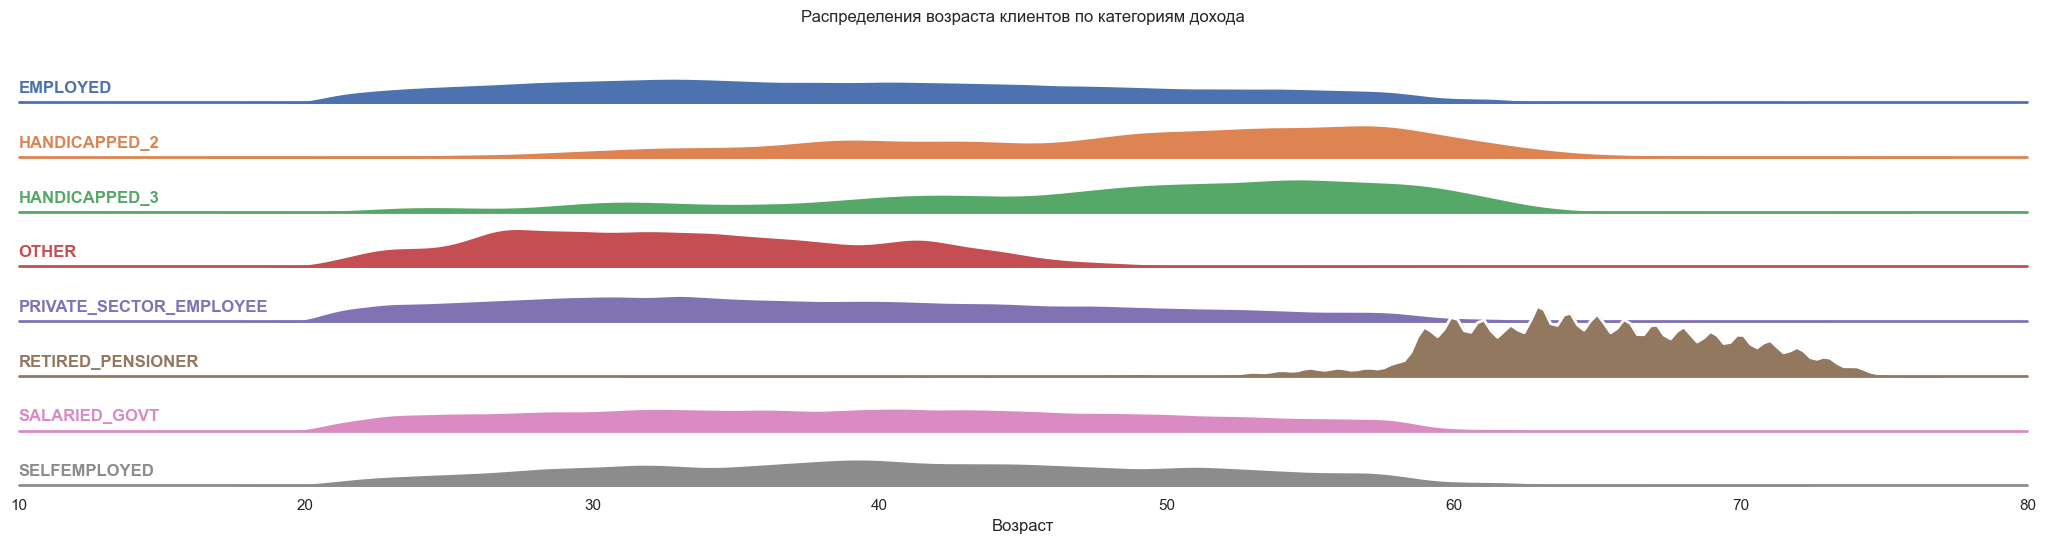

In [556]:
fig = overlapping_densities(
    "age_years",
    "incometype_1044T",
    dark_mode=False,
    title="Распределение возраста клиентов по категориям дохода",
    x_label="Возраст",
    x_lim=(10, 80),
    data=train_data,
    aspect=30.0,
    height=0.7,
    label_x_pos=0.0,
)
fig

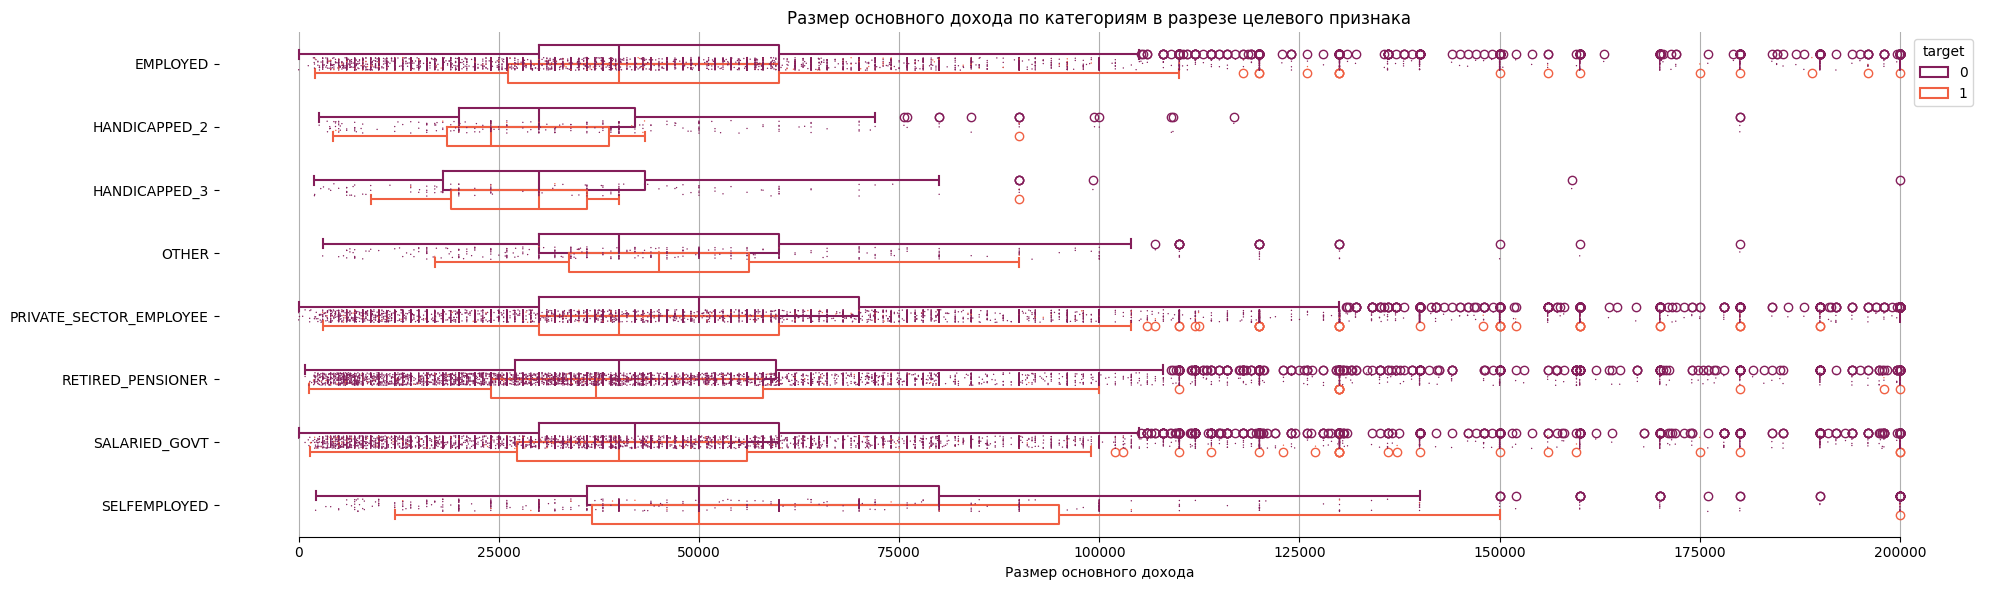

In [569]:
params = {
    "data": train_data,
    "x": "maininc_215A",
    "y": "incometype_1044T",
    "hue": "target",
    "palette": "rocket",
}
fig = boxplot_with_stripplot(
    x_label="Размер основного дохода",
    title="Размер основного дохода по категориям в разрезе целевого признака",
    dark_mode=0,
    **params
)
fig

Гипотеза верна. Сумма основного дохода клиента (maininc_215A) сильно зависит от вида дохода человека (Incometype_1044T). У работающих клиентов доход выше, чем у пенсионеров, инвалидов и других. Но интерквартильный размах у всех категорий находится в районе 25 - 50 тыс, кроме самозанятых. У заемщиков с высоким риском дефолта в большинстве случаев доход внутри группы чуть ниже, по медианному значению.

### Гипотеза 2

Размер ежемесячного платежа зависит от размера налога. Чем выше налог, тем выше себе может позволить клиент размер кредита (следовательно и ежемесячного платежа). Причем чем выше размер ежемесячного платежа, тем выше вероятность дефолта.

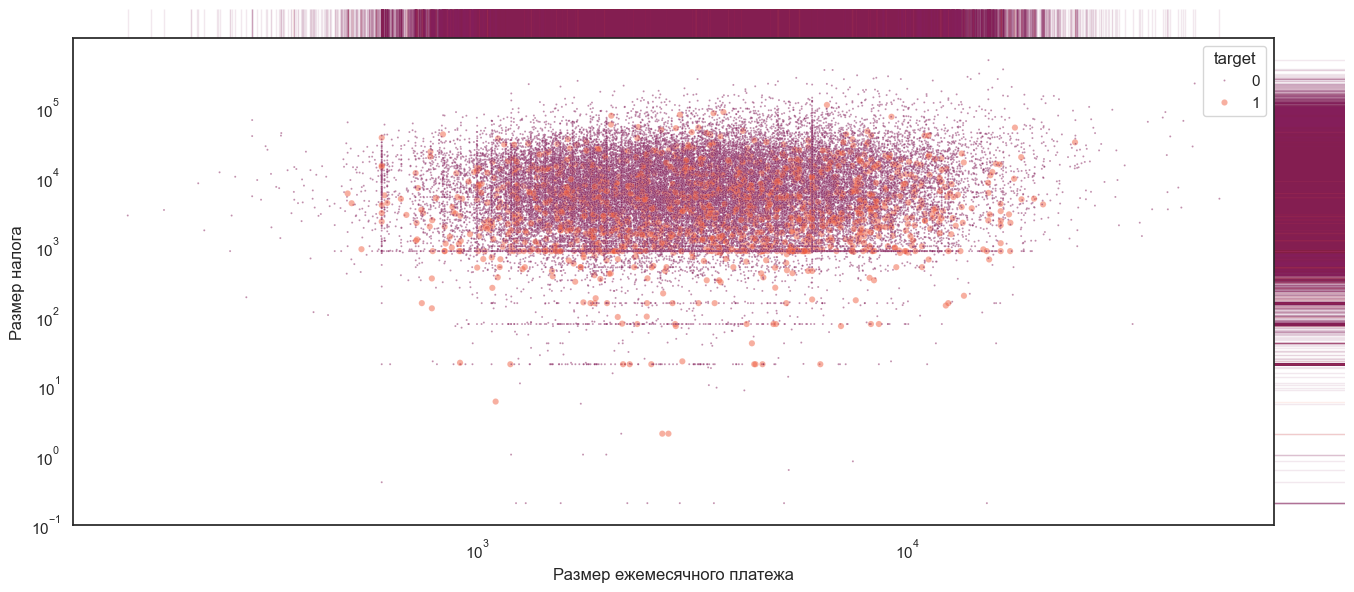

In [702]:
params = {
    "x": "annuity_780A",
    "y": "tax_amount_max",
    "hue": "target",
    "size_order": [1, 0],
    "sizes": (2, 20),
    "palette": "rocket",
}
fig = joint_plot(
    train_data,
    "target",
    x_label="Размер ежемесячного платежа",
    y_label="Размер налога",
    dark_mode=0,
    **params
)
fig

In [705]:
cor = train_data[["annuity_780A", "tax_amount_max"]].corr(method="spearman")
coef = np.triu(cor)[0][1]
coef

0.10739137787546744

Гипотеза не верна. Размер ежемесячного платежа размер налога независимы (коэффициент корреляции 0.1). Причем зависимости с целевым признаком (target) тоже нет.

### Гипотеза 3

Вероятность дефолта зависит от трудового стажа. Чем меньше стаж тем вероятность выше.

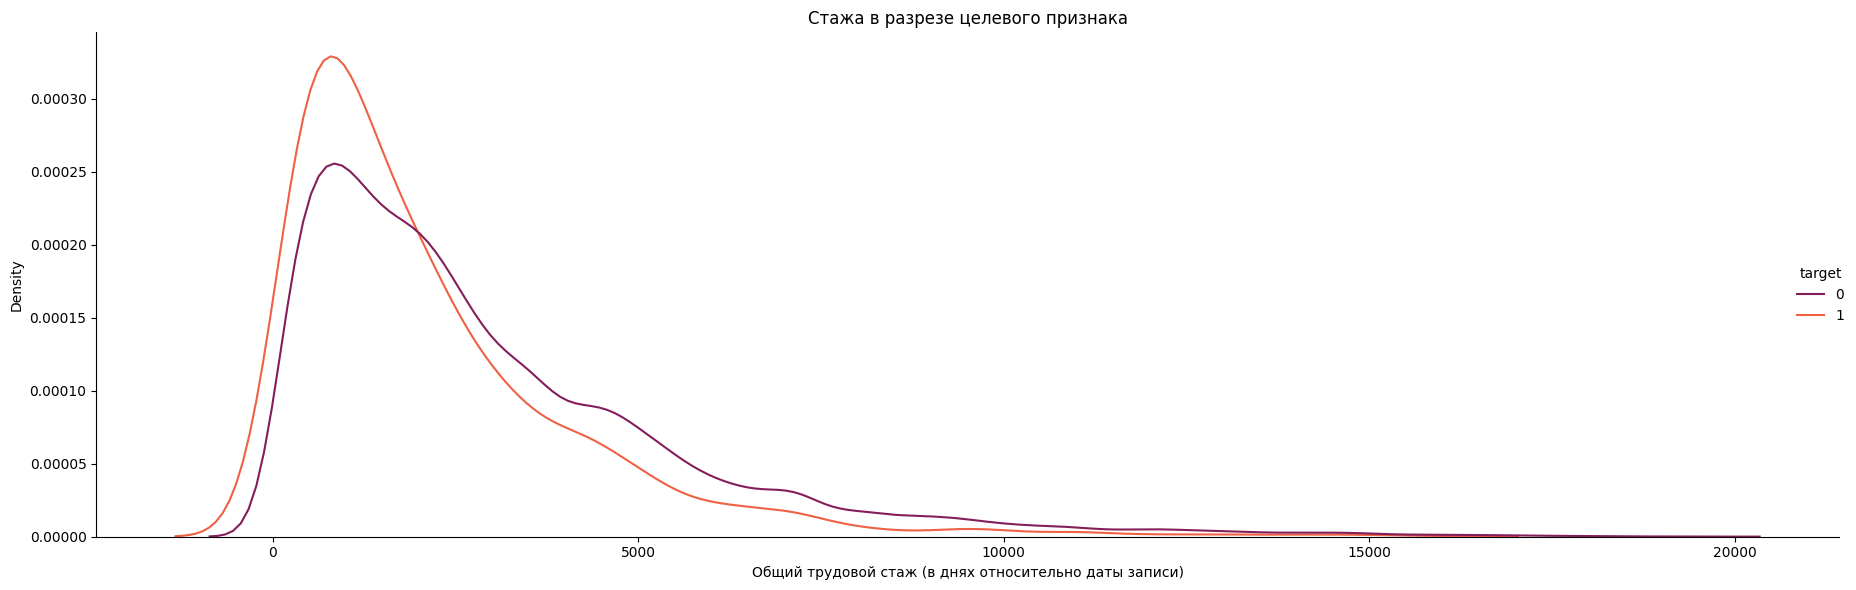

In [750]:
params = {
    "data": train_data,
    "x": "employedfrom",
    "hue": "target",
    "palette": "rocket",
}
fig = displot(
    x_label="Общий трудовой стаж (в днях относительно даты записи)",
    title="Стаж в разрезе целевого признака",
    dark_mode=0,
    **params
)
fig

In [729]:
check_distributions_for_similarity(
    train_data[["employedfrom", "target"]], "employedfrom", "target"
)

Распределение для признака employedfrom target = 1 нормальное, pvalue = 1.0
Распределение для признака employedfrom target = 0 нормальное, pvalue = 1.0
Средние различны, p-value=6.153512172315184e-45
T test statistic = -14.076617418455076, pvalue = 6.153512172315184e-45


Наблюдаем статистически значимую разницу. Гипотеза верна. Клиенты с меньшим стажем чаще имеют дефолт по кредиту.

### Гипотеза 4

Размер активного кредита зависит от размера непогашенного долга по всем кредитам. Чем выше долг, тем ниже размер активного кредита.

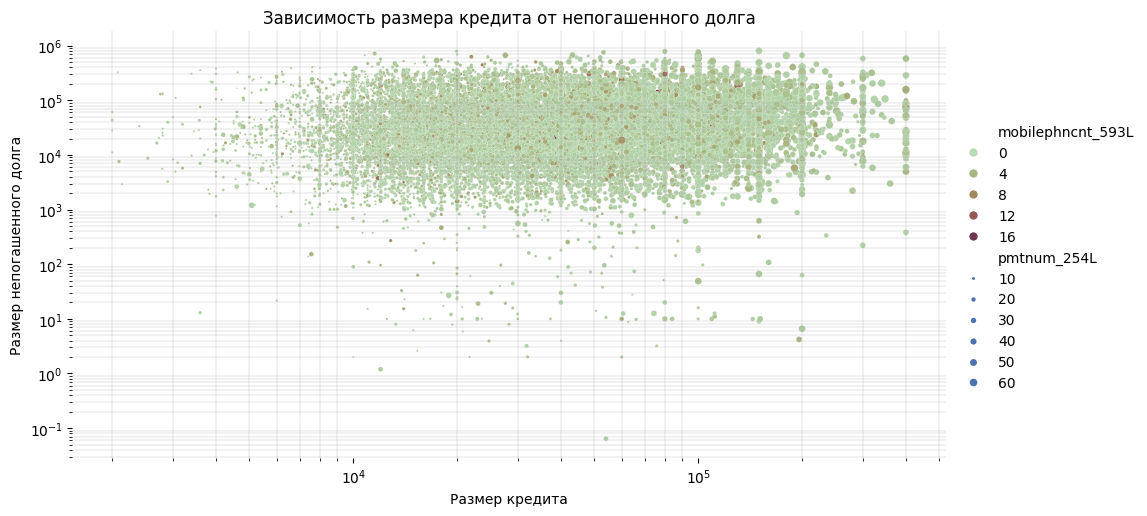

In [783]:
params = {
    "data": train_data,
    "x": "credamount_770A",
    "y": "debt_outstand_total",
    "hue": "mobilephncnt_593L",
    "size": "pmtnum_254L",
    "sizes": (1, 30),
    "color": "b",
    "aspect": 2.0,
}
g = relplot(
    x_label="Размер кредита",
    y_label="Размер непогашенного долга",
    title="Зависимость размера кредита от непогашенного долга",
    dark_mode=0,
    **params,
)
g

In [782]:
cor = train_data[["credamount_770A", "debt_outstand_total"]].corr(method="spearman")
coef = np.triu(cor)[0][1]
coef

0.07245476896050027

Видим, что размер активного кредита не связан от размером непогашенного долга по всем кредитам. Коэффициент корреляции близок к нулю. Также отсутсвует связь с количеством клиентов с таким же номер телефона и количеством платеже по кредиту.

### Гипотеза 5

При недавней просрочке по предыдущему кредиту вероятность дефолта по текущему кредиту будет выше.

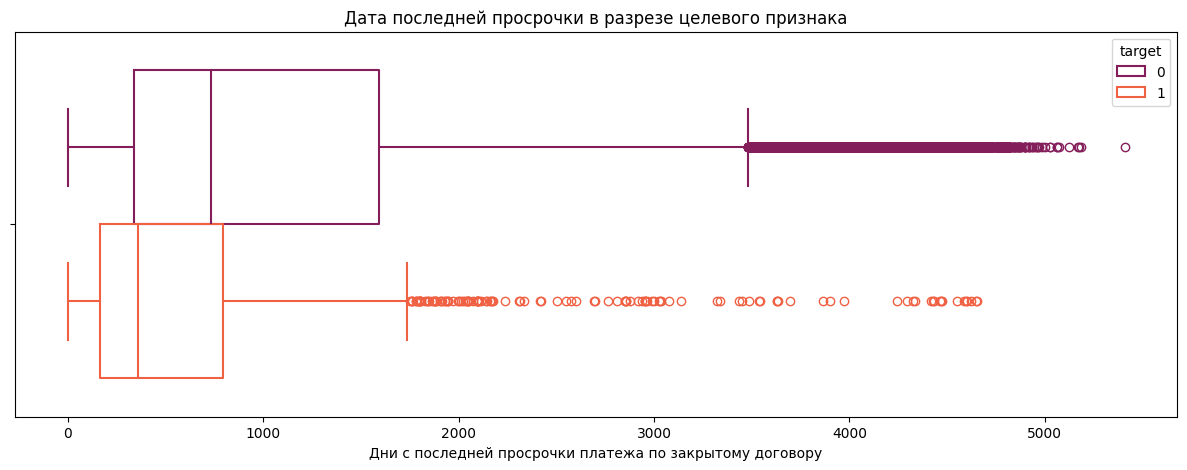

In [792]:
params = {
    "data": train_data,
    "x": "numberofoverdueinstlmaxdat_148D",
    "hue": "target",
    "palette": "rocket",
}
f = boxplot(
    x_label="Дни с последней просрочки платежа по закрытому договору",
    title="Дата последней просрочки в разрезе целевого признака",
    dark_mode=0,
    **params,
)
f

In [31]:
check_distributions_for_similarity(
    train_data[["numberofoverdueinstlmaxdat_148D", "target"]],
    "numberofoverdueinstlmaxdat_148D",
    "target",
)

Распределение для признака numberofoverdueinstlmaxdat_148D target = 1 нормальное, pvalue = 1.0
Распределение для признака numberofoverdueinstlmaxdat_148D target = 0 нормальное, pvalue = 1.0
Средние различны, p-value=1.1267058289392278e-61
T test statistic = 16.601267099213175, pvalue = 1.1267058289392278e-61


Гипотеза верна. При недавней просрочке по предыдущему кредиту вероятность дефолта по текущему кредиту будет выше. Наблюдаем статистически значимые отличия между двумя группами.

### Гипотеза 6

Чем больше клиент закрытыл кредитов и чем больше их общая сумма, тем меньше вероятность дефолта.

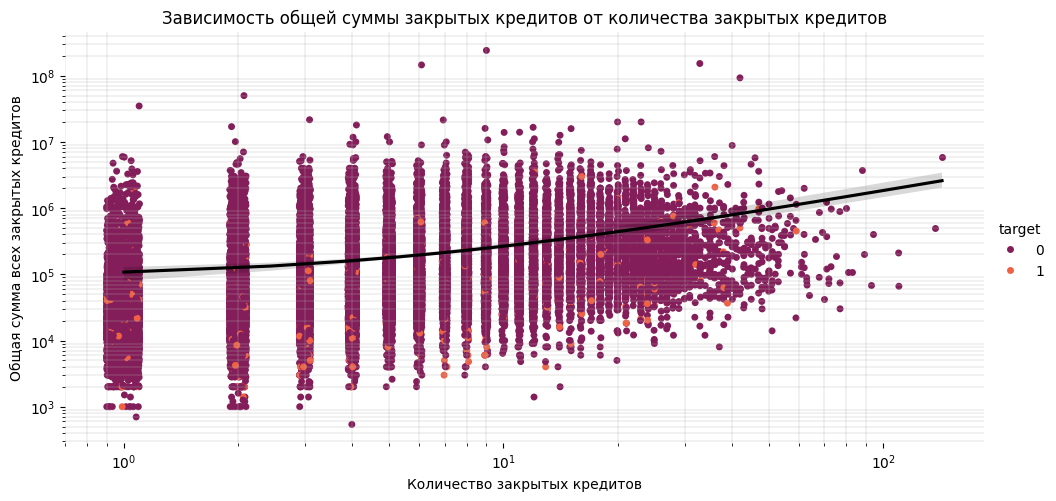

In [811]:
params = {
    "data": train_data,
    "x": "num_cred_closed",
    "y": "total_amount_closed_contracts",
    "hue": "target",
    'aspect': 2.,
    "palette": "rocket",
}
f = cat_reg_plot(
    x_label="Количество закрытых кредитов",
    y_label="Общая сумма всех закрытых кредитов",
    title="Зависимость общей суммы закрытых кредитов от количества закрытых кредитов",
    dark_mode=0,
    **params,
)
f

In [32]:
check_distributions_for_similarity(
    train_data[["num_cred_closed", "target"]],
    "num_cred_closed",
    "target",
)

Распределение для признака num_cred_closed target = 1 нормальное, pvalue = 1.0
Распределение для признака num_cred_closed target = 0 нормальное, pvalue = 1.0
Средние различны, p-value=2.1531779882894057e-12
T test statistic = 7.025556750665192, pvalue = 2.1531779882894057e-12


In [807]:
check_distributions_for_similarity(
    train_data[["total_amount_closed_contracts", "target"]],
    "total_amount_closed_contracts",
    "target",
)

Распределение для признака total_amount_closed_contracts target = 1 нормальное, pvalue = 1.0
Распределение для признака total_amount_closed_contracts target = 0 нормальное, pvalue = 1.0
Средние различны, p-value=0.015674527462711633
T test statistic = 2.4164871968771964, pvalue = 0.015674527462711633


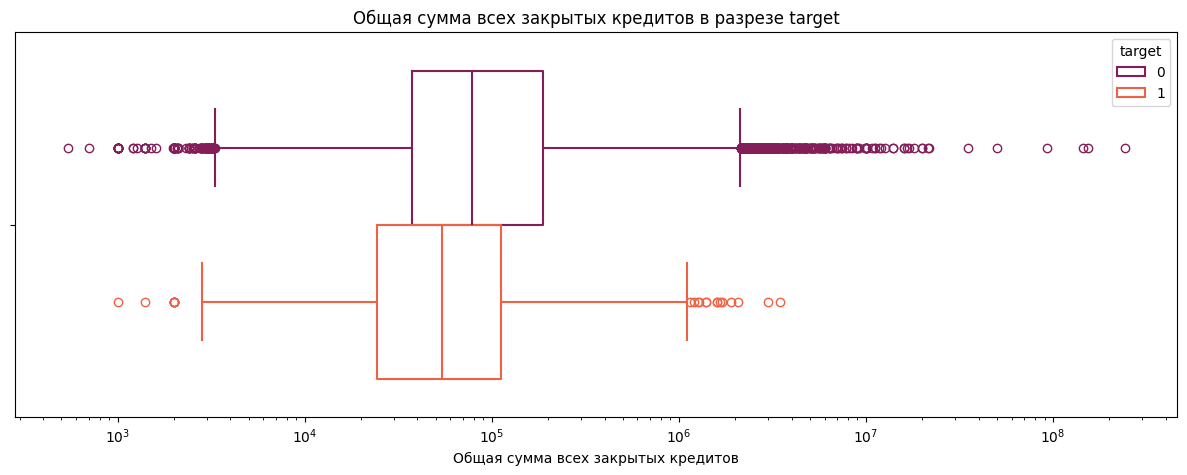

In [810]:
params = {
    "data": train_data,
    "x": "total_amount_closed_contracts",
    "hue": "target",
    "palette": "rocket",
    'log_scale': True
}
f = boxplot(
    x_label="Общая сумма всех закрытых кредитов",
    title="Общая сумма всех закрытых кредитов в разрезе target",
    dark_mode=0,
    **params,
)
f

Гипотеза полностью подтверждена. Чем больше клиент закрытыл кредитов и чем больше их общая сумма, тем меньше вероятность дефолта. Наблюдается статистически значимая разница между группами с target 0 и 1.

## Выводы

- Сумма основного дохода клиента (maininc_215A) сильно зависит от вида дохода человека (Incometype_1044T). У работающих клиентов доход выше, чем у пенсионеров, инвалидов и других. Но интерквартильный размах у всех категорий находится в районе 25 - 50 тыс, кроме самозанятых. У заемщиков с высоким риском дефолта в большинстве случаев доход внутри группы чуть ниже, по медианному значению.
- Размер ежемесячного платежа размер налога независимы (коэффициент корреляции 0.1). Причем зависимости с целевым признаком (target) тоже нет.
- Клиенты с меньшим стажем чаще имеют дефолт по кредиту.
- Видим, что размер активного кредита не связан от размером непогашенного долга по всем кредитам. Коэффициент корреляции близок к нулю. Также отсутсвует связь с количеством клиентов с таким же номер телефона и количеством платеже по кредиту.
- При недавней просрочке по предыдущему кредиту вероятность дефолта по текущему кредиту будет выше. Наблюдаем статистически значимые отличия между двумя группами.
- Чем больше клиент закрытыл кредитов и чем больше их общая сумма, тем меньше вероятность дефолта. Наблюдается статистически значимая разница между группами с target 0 и 1.